In [2]:
#!pip install pyro-ppl

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine

In [1]:
from preprocess import preprocess

X_tr,y_tr,X_ts,y_ts = preprocess()

/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


In [228]:
#!pip install http://download.pytorch.org/whl/cpu/torch-0.4.0-cp27-cp27mu-linux_x86_64.whl 
#!pip install pyro-ppl

import os
from functools import partial
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import math

import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Uniform, Delta, LogNormal
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.optim import Adam
from pyro.distributions.util import logsumexp
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
import pyro.poutine as poutine


# The true model, with randomly generated weights and fixed noise level
#noise_level = 0.1
x = X_tr
y = y_tr

In [229]:
x.shape

torch.Size([20660, 19])

In [230]:
pyro.enable_validation(True)
pyro.clear_param_store()

In [231]:
# # The prior
# @config_enumerate
# def model(x,y):
#     with pyro.plate('locs', x.shape[1]):
#         w_prior = pyro.sample('w_prior',Normal(torch.tensor(0.0), torch.tensor(1.0)))
#     b_prior = pyro.sample('b_prior',Normal(torch.tensor([1.0]), torch.tensor([5.0])))
#     # b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
#     w_prior = w_prior.unsqueeze(-1)

#     prediction_mean = b_prior + torch.mm(x, w_prior)
#     #priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
#     sigma = pyro.sample("sigma", LogNormal(0.,5.))

#     # lifted_module = pyro.random_module("module", regression_model, priors)
#     # lifted_reg_model = lifted_module()

#     #mu = a + w_prior*x
#     #for i in pyro.plate("data_loop", len(x)):
#     with pyro.plate("map", len(x)):
#         # prediction_mean = lifted_reg_model(x).squeeze(-1)
#         # prediction_mean =  w_prior*x
#         pyro.sample("obs", Normal(prediction_mean, sigma), obs=y)
    
#     return y


# from pyro.infer.autoguide import AutoDiagonalNormal, AutoDelta
# from torch.distributions import constraints
# guide = AutoDelta(model)


In [232]:
# The prior
@config_enumerate
def model(x,y):
    w_prior1 = pyro.sample('w_prior1',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior2 = pyro.sample('w_prior2',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior3 = pyro.sample('w_prior3',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior4 = pyro.sample('w_prior4',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior5 = pyro.sample('w_prior5',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior6 = pyro.sample('w_prior6',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior7 = pyro.sample('w_prior7',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior8 = pyro.sample('w_prior8',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior9 = pyro.sample('w_prior9',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior10 = pyro.sample('w_prior10',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior11 = pyro.sample('w_prior11',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior12 = pyro.sample('w_prior12',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior13 = pyro.sample('w_prior13',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior14 = pyro.sample('w_prior14',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior15 = pyro.sample('w_prior15',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior16 = pyro.sample('w_prior16',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior17 = pyro.sample('w_prior17',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior18 = pyro.sample('w_prior18',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    w_prior19 = pyro.sample('w_prior19',Normal(torch.tensor(0.0), torch.tensor(1.0)))
    
    b_prior = pyro.sample('b_prior',Normal(torch.tensor([1.0]), torch.tensor([5.0])))
    # b_prior = Normal(torch.tensor([[8.]]), torch.tensor([[1000.]])).to_event(1)
    # w_prior = w_prior.unsqueeze(-1)

    prediction_mean = b_prior + w_prior1 * x[:, 0] + \
                      w_prior2 * x[:, 1] + w_prior3 * x[:, 2] + \
                      w_prior4 * x[:, 3] + w_prior5 * x[:, 4] + \
                      w_prior6 * x[:, 5] + w_prior7 * x[:, 6] + \
                      w_prior8 * x[:, 7] + w_prior9 * x[:, 8] + \
                      w_prior10 * x[:, 9] + w_prior11 * x[:, 10] + \
                      w_prior12 * x[:, 11] + w_prior13 * x[:, 12] + \
                      w_prior14 * x[:, 13] + w_prior15 * x[:, 14] + \
                      w_prior16 * x[:, 15] + w_prior17 * x[:, 16] + \
                      w_prior18 * x[:, 17] + w_prior19 * x[:, 18]
    
    sigma = pyro.sample("sigma", LogNormal(0.,5.))

    # lifted_module = pyro.random_module("module", regression_model, priors)
    # lifted_reg_model = lifted_module()

    #mu = a + w_prior*x
    #for i in pyro.plate("data_loop", len(x)):
    with pyro.plate("map", len(x)):
        # prediction_mean = lifted_reg_model(x).squeeze(-1)
        # prediction_mean =  w_prior*x
        pyro.sample("obs", Normal(prediction_mean, sigma), obs=y)


# from pyro.infer.autoguide import AutoDiagonalNormal, AutoDelta
# from torch.distributions import constraints
# guide = AutoDelta(model)


In [233]:
def guide(x,y):
    
    weights_loc = pyro.param('weights_loc', torch.randn(x.shape[1]))
    weights_scale = pyro.param('weights_scale', torch.ones(1), constraint=constraints.positive)        
    
    bias_loc = pyro.param('bias_loc', torch.randn(1))
    bias_scale = pyro.param('bias_scale', torch.ones(1), constraint=constraints.positive)
    
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.0), constraint=constraints.positive)

    
    w_prior1 = pyro.sample('w_prior1',Normal(weights_loc[0], weights_scale))
    w_prior2 = pyro.sample('w_prior2',Normal(weights_loc[1], weights_scale))
    w_prior3 = pyro.sample('w_prior3',Normal(weights_loc[2], weights_scale))
    w_prior4 = pyro.sample('w_prior4',Normal(weights_loc[3], weights_scale))
    w_prior5 = pyro.sample('w_prior5',Normal(weights_loc[4], weights_scale))
    w_prior6 = pyro.sample('w_prior6',Normal(weights_loc[5], weights_scale))
    w_prior7 = pyro.sample('w_prior7',Normal(weights_loc[6], weights_scale))
    w_prior8 = pyro.sample('w_prior8',Normal(weights_loc[7], weights_scale))
    w_prior9 = pyro.sample('w_prior9',Normal(weights_loc[8], weights_scale))
    w_prior10 = pyro.sample('w_prior10',Normal(weights_loc[9], weights_scale))
    w_prior11 = pyro.sample('w_prior11',Normal(weights_loc[10], weights_scale))
    w_prior12 = pyro.sample('w_prior12',Normal(weights_loc[11], weights_scale))
    w_prior13 = pyro.sample('w_prior13',Normal(weights_loc[12], weights_scale))
    w_prior14 = pyro.sample('w_prior14',Normal(weights_loc[13], weights_scale))
    w_prior15 = pyro.sample('w_prior15',Normal(weights_loc[14], weights_scale))
    w_prior16 = pyro.sample('w_prior16',Normal(weights_loc[15], weights_scale))
    w_prior17 = pyro.sample('w_prior17',Normal(weights_loc[16], weights_scale))
    w_prior18 = pyro.sample('w_prior18',Normal(weights_loc[17], weights_scale))
    w_prior19 = pyro.sample('w_prior19',Normal(weights_loc[18], weights_scale))
    
    b_prior = pyro.sample('b_prior',Normal(bias_loc, bias_scale))

    sigma = pyro.sample("sigma", LogNormal(sigma_loc, torch.tensor(0.05)))

    prediction_mean = b_prior + w_prior1 * x[:, 0] + \
                      w_prior2 * x[:, 1] + w_prior3 * x[:, 2] + \
                      w_prior4 * x[:, 3] + w_prior5 * x[:, 4] + \
                      w_prior6 * x[:, 5] + w_prior7 * x[:, 6] + \
                      w_prior8 * x[:, 7] + w_prior9 * x[:, 8] + \
                      w_prior10 * x[:, 9] + w_prior11 * x[:, 10] + \
                      w_prior12 * x[:, 11] + w_prior13 * x[:, 12] + \
                      w_prior14 * x[:, 13] + w_prior15 * x[:, 14] + \
                      w_prior16 * x[:, 15] + w_prior17 * x[:, 16] + \
                      w_prior18 * x[:, 17] + w_prior19 * x[:, 18]

In [234]:
# def guide(x,y):
#     weights_loc = pyro.param('weights_loc', torch.randn(1))#.expand([])
#     weights_scale = pyro.param('weights_scale', torch.ones(1), constraint=constraints.positive)        
#     sigma_loc = pyro.param('sigma_loc', torch.tensor(1.0), constraint=constraints.positive)
#     bias_loc = pyro.param('bias_loc', torch.randn(1))#.expand([])
#     bias_scale = pyro.param('bias_scale', torch.ones(1), constraint=constraints.positive)        
#     # print (pyro.param('weights_scale'))
#     # print (pyro.param('bias_scale'))

#     with pyro.plate('locs', x.shape[1]):
#         w_prior = pyro.sample('w_prior',Normal(weights_loc, weights_scale))
    
#     b_prior = pyro.sample('b_prior',Normal(bias_loc, bias_scale))

#     sigma = pyro.sample("sigma", LogNormal(sigma_loc, torch.tensor(0.05)))
#    # print (b_prior.shape,x.shape, w_prior.shape)
#     w_prior = w_prior.unsqueeze(-1)

#     prediction_mean = b_prior + torch.mm(x, w_prior)


In [235]:
model(x,y)

In [236]:
svi = pyro.infer.SVI(model, 
          guide, 
          optim.Adam({"lr": .005}), 
          loss=pyro.infer.Trace_ELBO(max_plate_nesting=1), num_samples=1000)

pyro.clear_param_store()
rec_loss = []
for i in range(1000):
    loss = svi.step(x,y)
    rec_loss.append(loss)
    if not i % 50:
        print('Iter %d, loss = %g' % (i,loss))

# optimizer = pyro.optim.SGD({"lr": 1e-4, "momentum": 0.1})
# pyro.clear_param_store()
# svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO(max_plate_nesting=1))
# rec_loss = []
# for i in range(100):
#     loss = svi.step(x,y)
#     rec_loss.append(loss)
#     print('Iter %d, loss = %g' % (i,loss))

Iter 0, loss = 76731.6
Iter 50, loss = 59968.6
Iter 100, loss = 52277.6
Iter 150, loss = 52177.5
Iter 200, loss = 52731.3
Iter 250, loss = 48728.6
Iter 300, loss = 43769.6
Iter 350, loss = 40260.2
Iter 400, loss = 36609.9
Iter 450, loss = 35717.4
Iter 500, loss = 34222.6
Iter 550, loss = 32773.8
Iter 600, loss = 28594.4
Iter 650, loss = 28292.9
Iter 700, loss = 28594.7
Iter 750, loss = 27361.6
Iter 800, loss = 27659.7
Iter 850, loss = 25599.5
Iter 900, loss = 25769.3
Iter 950, loss = 25359


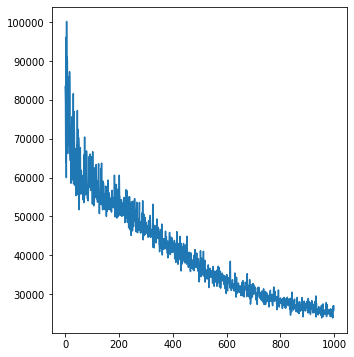

In [224]:
fig = plt.figure(figsize = (18,6))
plt.subplot(131)
plt.plot(rec_loss)
plt.show()
# plt.subplot(132)
# plt.plot(x.numpy(), y.numpy(), '+')

In [225]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [226]:
estimates = svi.run(x,y)
sites = ['w_prior1', 'w_prior2', 'w_prior3', 'w_prior4', 'w_prior5', 'w_prior6', 
         'w_prior7', 'w_prior8', 'w_prior9', 'w_prior10', 'w_prior11', 'w_prior12', 'w_prior13', 'w_prior14', 'w_prior15', 'w_prior16', 
         'w_prior17', 'w_prior18', 'w_prior19', 'b_prior', 'sigma']
svi_samples = {site: EmpiricalMarginal(estimates, sites=site).enumerate_support().detach().cpu().numpy()
                       for site in sites}

In [227]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: w_prior1
       mean       std        5%       25%       50%       75%       95%
0  0.022787  0.104829 -0.143971 -0.049555  0.020003  0.086056  0.202148 

Site: w_prior2
       mean       std        5%       25%       50%       75%       95%
0  0.013348  0.110017 -0.170473 -0.059731  0.011931  0.084301  0.194191 

Site: w_prior3
       mean       std        5%       25%       50%       75%       95%
0  0.005482  0.106771 -0.167944 -0.061693  0.004551  0.078375  0.182356 

Site: w_prior4
       mean       std        5%       25%       50%       75%       95%
0 -0.087273  0.109757 -0.264956 -0.165052 -0.086246 -0.006343  0.088485 

Site: w_prior5
       mean       std        5%       25%     50%       75%       95%
0  0.042948  0.106841 -0.133472 -0.032272  0.0468  0.117144  0.215822 

Site: w_prior6
       mean      std        5%       25%       50%       75%      95%
0 -0.012093  0.11075 -0.197619 -0.085426 -0.014394  0.060888  0.17122 

Site: w_prior7
       mean       std      

In [150]:
means = summary(svi_samples)

In [169]:
post_means = []
for site in means:
    if site != 'sigma' and site != 'b_prior':
        post_means.append(means[site]['mean'].values)

In [194]:
a = np.array(post_means)
a.flatten()
a = torch.tensor(a)
a = a.type(torch.FloatTensor)
sigma = torch.tensor(means['sigma']['mean'].values).type(torch.FloatTensor)
bias = torch.tensor(means['b_prior']['mean'].values).type(torch.FloatTensor)

In [200]:
def get_pred(bias, weights, scale, x_test):
    preds = bias + torch.mm(x_test, weights)
    return preds

In [201]:
pr = get_pred(bias, a, sigma, X_ts)